# LOv rewriting rules

The aim of this notebook is to rewrite a circuit using rewriting rules based on the article: *LOv-Calculus: A Graphical Language for Linear Optical Quantum Circuits*.

We show how to use these rewriting rules to generate unique triangular normal forms.

In [1]:
import perceval as pcvl
from perceval.utils.algorithms.optimize import optimize
from perceval.utils.algorithms.norm import frobenius
import random

from perceval.rendering import DisplayConfig, SymbSkin
DisplayConfig.select_skin(SymbSkin)

This is the first rewrite rule used in this noteobok. It is the rule 37 in the article.

![rewrite37](../_static/img/rewrite37.png)

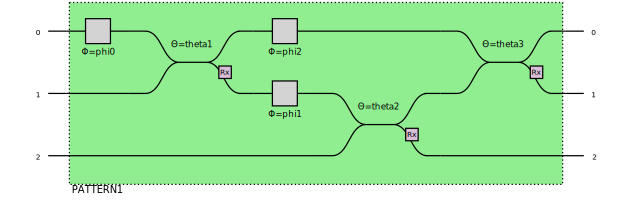

In [2]:
pattern1=pcvl.Circuit(3, name="pattern1")//(0,pcvl.PS(pcvl.P("phi0")))//(0,pcvl.BS(theta=pcvl.P("theta1")))//(0,pcvl.PS(pcvl.P("phi2")))//(1,pcvl.PS(pcvl.P("phi1")))//(1,pcvl.BS(theta=pcvl.P("theta2")))//(0,pcvl.BS(theta=pcvl.P("theta3")))
pattern1._color = "lightgreen"
pcvl.pdisplay(pcvl.Circuit(3).add(0,pattern1,False), recursive=True)

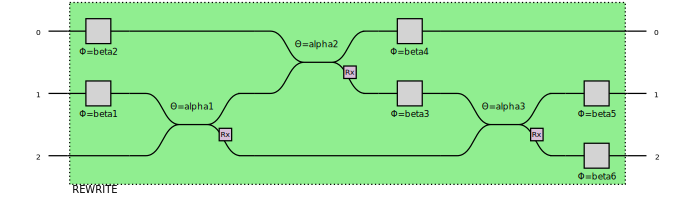

In [3]:
rewrite1=pcvl.Circuit(3, name="rewrite")//(0,pcvl.PS(pcvl.P("beta2")))//(1,pcvl.PS(pcvl.P("beta1")))//(1,pcvl.BS(theta=pcvl.P("alpha1")))//(0,pcvl.BS(theta=pcvl.P("alpha2")))//(1,pcvl.PS(pcvl.P("beta3")))//(1,pcvl.BS(theta=pcvl.P("alpha3")))//(0,pcvl.PS(pcvl.P("beta4")))//(1,pcvl.PS(pcvl.P("beta5")))//(2,pcvl.PS(pcvl.P("beta6")))
rewrite1._color = "lightgreen"
pcvl.pdisplay(pcvl.Circuit(3).add(0,rewrite1,False), recursive=True)

Let us implement now the rule number 1.

![rewrite1](../_static/img/rewrite1.png)

In [4]:
pattern2=pcvl.Circuit(1, name="pattern2")//pcvl.PS(pcvl.P("phi1"))//pcvl.PS(pcvl.P("phi2"))
rewrite2=pcvl.Circuit(1, name="rewrite2")//pcvl.PS(pcvl.P("phi"))

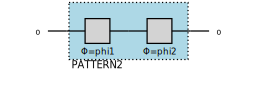

In [5]:
pcvl.pdisplay(pcvl.Circuit(1).add(0,pattern2,False), recursive=True)

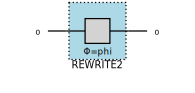

In [6]:
pcvl.pdisplay(pcvl.Circuit(1).add(0,rewrite2,False), recursive=True)

In fact, this rule has been directly implemented in Perceval, with the call of `simplify`.

In [7]:
from perceval.utils.algorithms.simplification import simplify

The third rule used in this notebook is the following one:

![rewrite33](../_static/img/rewrite33.png)

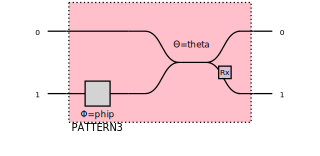

In [8]:
pattern3=pcvl.Circuit(2, name="pattern3")//(1,pcvl.PS(pcvl.P("phip")))//(0,pcvl.BS(theta=pcvl.P("theta")))
pattern3._color = "pink"
pcvl.pdisplay(pcvl.Circuit(2).add(0,pattern3,False), recursive=True)

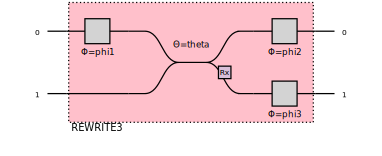

In [9]:
rewrite3=pcvl.Circuit(2, name="rewrite3")//(0,pcvl.PS(pcvl.P("phi1")))//(0,pcvl.BS(theta=pcvl.P("theta")))//(0,pcvl.PS(pcvl.P("phi2")))//(1,pcvl.PS(pcvl.P("phi3")))
rewrite3._color = "pink"
pcvl.pdisplay(pcvl.Circuit(2).add(0,rewrite3,False), recursive=True)

And the fourth rule is the rule 38 in the article.

![rewrite38](../_static/img/rewrite38.png)

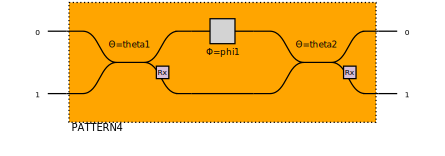

In [10]:
pattern4=pcvl.Circuit(2, name="pattern4")//(0,pcvl.BS(theta=pcvl.P("theta1")))//(0,pcvl.PS(pcvl.P("phi1")))//(0,pcvl.BS(theta=pcvl.P("theta2")))
pattern4._color = "orange"
pcvl.pdisplay(pcvl.Circuit(2).add(0,pattern4,False), recursive=True)

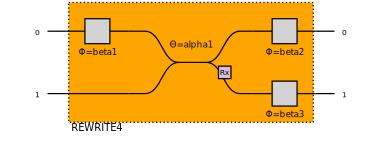

In [11]:
rewrite4=pcvl.Circuit(2, name="rewrite4")//(0,pcvl.PS(pcvl.P("beta1")))//(0,pcvl.BS(theta=pcvl.P("alpha1")))//(0,pcvl.PS(pcvl.P("beta2")))//(1,pcvl.PS(pcvl.P("beta3")))
rewrite4._color = "orange"
pcvl.pdisplay(pcvl.Circuit(2).add(0,rewrite4,False), recursive=True)

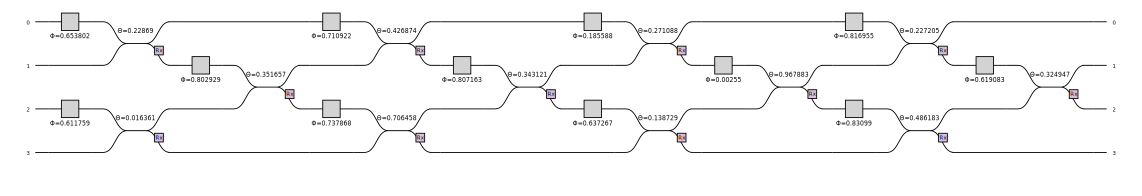

In [12]:
a=pcvl.GenericInterferometer(4, lambda idx:pcvl.Circuit(2)//pcvl.PS(phi=random.random())//pcvl.BS(theta=random.random()), depth=8, shape=pcvl.InterferometerShape.RECTANGLE)
pcvl.pdisplay(a, recursive=True, render_size=0.7)

## Normalizing Circuit

In [13]:
import drawsvg as draw

In [14]:
reverse = []
direct=[]
def draw_frame(a):
    if isinstance(a, pcvl.Circuit):
        d = pcvl.pdisplay(a, recursive=True, render_size=0.6)
        reverse.insert(0, d)
        direct.append(d)
        return d
    return a

rules = [(pattern1, rewrite1, "lightgreen"), # (pattern2, rewrite2, "lightblue"),
         (pattern3, rewrite3, "pink"), (pattern4, rewrite4, "orange")]

with draw.frame_animate_jupyter(draw_frame, delay=0.1) as anim:
    anim.draw_frame(a)
    while True:
        found = False
        for pattern, rewrite, color in rules:
            start_pos = 0
            while True:
                print("matching pattern", pattern.name)
                matched = a.match(pattern, browse=True, pos=start_pos)
                if matched is None:
                    break
                print("matching ok", matched.v_map)
                idx = a.isolate(list(matched.pos_map.keys()), color=color)
                anim.draw_frame(a)
                for k, v in matched.v_map.items():
                    pattern.param(k).set_value(v)
                v = pattern.compute_unitary(False)
                print("optimizing rewrite",rewrite.name)
                res = optimize(rewrite, v, frobenius, sign=-1)
                print("found params with distance", res.fun)
                subc = rewrite.copy()
                found = True
                a.replace(idx, subc, merge=False)
                anim.draw_frame(a)
                a.replace(idx, subc, merge=True)
                pattern.reset_parameters()
                rewrite.reset_parameters()
                a = simplify(a)
                anim.draw_frame(a)
                start_pos = idx
        if not found:
            break

matching pattern pattern1
matching pattern pattern3
matching pattern pattern4


This representation is exactly the normal form that we wanted to obtain !

## Reference

> A. Clément, N. Heurtel, S. Mansfield, S. Perdrix, B. Valiron. LOv-Calculus: A Graphical Language for Linear Optical Quantum Circuits, 47th International Symposium on Mathematical Foundations of Computer Science [MFCS](https://doi.org/10.4230/LIPIcs.MFCS.2022.35), 35:1--35:16 (2022).